In [1]:
import collections
import functools
import http
import json
import logging
import os
import urllib

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm.notebook import tqdm

In [2]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

tqdm.pandas(leave=False)

logging.basicConfig(format='%(asctime)s [%(levelname)s/%(processName)s] '
                           '%(module)s.%(funcName)s : %(message)s',
                    level=logging.INFO)

/home/wout/.conda/envs/dorrestein/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
@functools.lru_cache(None)
def pubchem_name_to_inchikey(name):
    try:
        with urllib.request.urlopen(
                f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/'
                f'{name}/property/inchikey/TXT') as f_url:
            return f_url.read().decode().strip().split()[0]
    except urllib.error.HTTPError:
        return None

    
@functools.lru_cache(None)
def smiles_to_inchikey(smiles):
    try:
        mol = Chem.rdmolfiles.MolFromSmiles(smiles)
    except ValueError:
        mol = None
    return Chem.rdinchi.MolToInchiKey(mol) if mol is not None else None


@functools.lru_cache(None)
def inchikey_to_subclass(inchikey):
    try:
        with urllib.request.urlopen(f'https://gnps-classyfire.ucsd.edu/'
                                    f'entities/{inchikey}.json') \
                as f_url:
            return json.loads(f_url.read())['subclass']['chemont_id']
    except (urllib.error.HTTPError, AttributeError, TypeError, KeyError):
        return None

In [4]:
def get_matched_perc(identifications):
    tops, datasets, tools, match_type, perc_matched = [], [], [], [], []
    for top, dataset_ids in identifications.items():
        for dataset, tool_ids in dataset_ids.items():
            for tool, ids in tool_ids.items():
                tops.append(top)
                datasets.append(dataset)
                tools.append(tool)
                match_type.append('Direct match')
                perc_matched.append(
                    len(set(ids['InChIKey']) & compounds[dataset])
                    / len(compounds[dataset]))
                tops.append(top)
                datasets.append(dataset)
                tools.append(tool)
                match_type.append('Subclass match')
                perc_matched.append(
                    len(set(ids['subclass']) & subclasses[dataset])
                    / len(subclasses[dataset]))

    return pd.DataFrame({'Dataset': datasets, 'Tool': tools, 'Top': tops,
                         'Type': match_type,
                         'Compounds identified': perc_matched})

In [5]:
data_dir = '../data/deconvolution_comparison'
compounds = {
    'Metabolomics Workbench ST001154':
        set(pd.read_csv(os.path.join(
            data_dir, 'Metabolomics Workbench ST001154.csv'))['InChiKey']),
    'LECO beer aging':
        set(pd.read_csv(os.path.join(data_dir, 'LECO beer aging.csv'))
            ['Name'].apply(pubchem_name_to_inchikey)),
    'TMS derivatized blood serum':
        set(pd.read_csv(os.path.join(
                data_dir, 'TMS derivatized blood serum.csv'))['SMILES']
            .apply(smiles_to_inchikey))
}
subclasses = {dataset: set([inchikey_to_subclass(inchikey)
                            for inchikey in comp])
              for dataset, comp in compounds.items()}
for sc in subclasses.values():
    sc.discard(None)

In [6]:
task_ids = {
    'Metabolomics Workbench ST001154': {
        'MSHub': '4f2de61a', 'MZmine': '021f4818', 'MS-DIAL': '16d202bd'},
    'LECO beer aging': {
        'MSHub': '35445438', 'MZmine': '37971f05', 'MS-DIAL': 'dd21a47e'},
    'TMS derivatized blood serum': {
        'MSHub': 'c367af69', 'MZmine': '0e7ba6e3', 'MS-DIAL': '7e5cc6bc'}}

identifications = collections.defaultdict(
    lambda: collections.defaultdict(dict))
for top in (1, 10):
    for dataset, tools in task_ids.items():
        logging.info('Process %s', dataset)
        for tool, task_id in tools.items():
            logging.info('%s identifications', tool)
            # Read the GNPS task file.
            ids = (
                pd.read_csv(
                    os.path.join(
                        data_dir, f'MOLECULAR-LIBRARYSEARCH-GC-{task_id}-'
                        f'view_all_annotations_DB-main.tsv'),
                    sep='\t',
                    usecols=['#Scan#', 'INCHI', 'Smiles', 'MQScore'],
                    skipinitialspace=True)
                .dropna()
                .sort_values(['#Scan#', 'MQScore'], ascending=[True, False])
                .groupby('#Scan#').head(top))
            ids = ids[ids['MQScore'] > 0.7]
            # Get InChIKeys and subclasses for all identifications.
            ids['InChIKey'] = ids['Smiles'].apply(smiles_to_inchikey)
            ids['subclass'] = \
                ids['InChIKey'].progress_apply(inchikey_to_subclass)
            ids.dropna()
            
            identifications[top][dataset][tool] = ids

matched = get_matched_perc(identifications)
matched.to_csv('deconvolution_comparison.csv', index=False)

2020-04-02 16:48:27,084 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : Process Metabolomics Workbench ST001154
2020-04-02 16:48:27,085 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MSHub identifications


2020-04-02 16:49:08,941 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MZmine identifications


2020-04-02 16:49:17,188 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MS-DIAL identifications


2020-04-02 16:49:31,489 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : Process LECO beer aging
2020-04-02 16:49:31,491 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MSHub identifications


2020-04-02 16:51:20,617 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MZmine identifications


2020-04-02 16:52:17,171 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MS-DIAL identifications


2020-04-02 16:54:42,983 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : Process TMS derivatized blood serum
2020-04-02 16:54:42,984 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MSHub identifications


2020-04-02 16:55:04,805 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MZmine identifications


2020-04-02 16:55:37,351 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MS-DIAL identifications


2020-04-02 16:56:01,856 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : Process Metabolomics Workbench ST001154
2020-04-02 16:56:01,858 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MSHub identifications


2020-04-02 16:57:03,711 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MZmine identifications


2020-04-02 16:57:22,234 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MS-DIAL identifications


2020-04-02 16:58:01,838 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : Process LECO beer aging
2020-04-02 16:58:01,840 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MSHub identifications


2020-04-02 17:05:37,772 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MZmine identifications


2020-04-02 17:09:09,462 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MS-DIAL identifications


2020-04-02 17:17:11,796 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : Process TMS derivatized blood serum
2020-04-02 17:17:11,797 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MSHub identifications


2020-04-02 17:18:18,064 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MZmine identifications


2020-04-02 17:19:51,857 [INFO/MainProcess] <ipython-input-6-d1de5f21703a>.<module> : MS-DIAL identifications


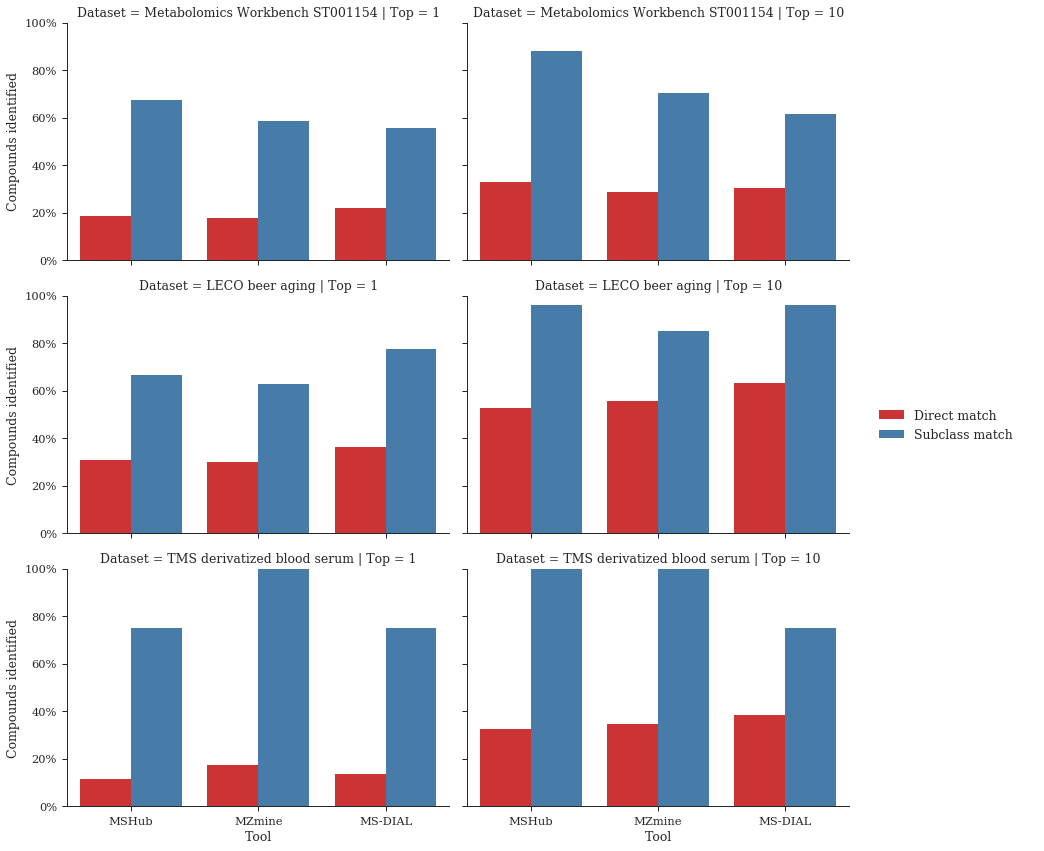

In [7]:
g = sns.catplot(x='Tool', y='Compounds identified', hue='Type', data=matched,
                row='Dataset', col='Top', kind='bar', height=4, aspect=1.5,
                legend=False)

for ax in g.axes.ravel():
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))

g.add_legend(fontsize='medium', borderpad=2)

sns.despine()

plt.savefig('deconvolution_comparison.png', dpi=300)
plt.show()
plt.close()

In [8]:
logging.shutdown()